In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
)

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [49]:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
    
print(device)

mps


In [50]:
# 1. Parameters
BATCH_SIZE = 64
EMBED_DIM = 128
HIDDEN_DIM = 128
EPOCHS = 20
MAX_VOCAB_SIZE = 25_000
MAX_SEQ_LEN = 256
DEVICE = device

RANDOM_SEED = 27
torch.manual_seed(RANDOM_SEED)

In [51]:
device

'mps'

In [52]:
import os

def load_imdb_data(data_dir, split):
    """Loads IMDB reviews from disk. Returns list of (label, text) tuples."""
    data = []
    for label in ('pos', 'neg'):
        labeled_dir = os.path.join(data_dir, split, label)
        for fname in os.listdir(labeled_dir):
            if fname.endswith('.txt'):
                with open(os.path.join(labeled_dir, fname), encoding='utf-8') as f:
                    text = f.read()
                    data.append((label, text))
    return data

# Example usage:
train_data = load_imdb_data('../../ML_Tinkering_Python/data/aclImdb', 'train')
test_data = load_imdb_data('../../ML_Tinkering_Python/data/aclImdb', 'test')

In [26]:
# 3. Build Vocabulary
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_list):
    for label, text in data_list:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train_data),
    specials=["<unk>", "<pad>"],
    max_tokens=MAX_VOCAB_SIZE
)
vocab.set_default_index(vocab["<unk>"])

In [27]:
# 4. Text + Label Preprocessing
label_map = {"neg": 0, "pos": 1}

def process_text(text):
    tokens = tokenizer(text)
    token_ids = vocab(tokens)
    if len(token_ids) > MAX_SEQ_LEN:
        token_ids = token_ids[:MAX_SEQ_LEN]
    else:
        token_ids += [vocab["<pad>"]] * (MAX_SEQ_LEN - len(token_ids))
    return torch.tensor(token_ids, dtype=torch.long)

def process_label(label):
    return torch.tensor(label_map[label], dtype=torch.long)

In [28]:
# 5. Create PyTorch Dataset
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = []
        for label, text in samples:
            self.samples.append((process_text(text), process_label(label)))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

train_dataset = IMDBDataset(train_data)
test_dataset = IMDBDataset(test_data)

In [29]:
# 6. Handle Imbalanced Dataset (Weighted Loss)
labels = [label.item() for _, label in train_dataset]

class_counts = Counter(labels)

class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]

sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(
    sample_weights
    , num_samples=len(sample_weights)
    , replacement=True
)

In [30]:
# 7. Create DataLoaders
train_loader = DataLoader(
    train_dataset
    , batch_size=BATCH_SIZE
    , sampler=sampler
    , num_workers=0  # <-- Fix: Use single process (avoid pickle issues)
)

test_loader = DataLoader(
    test_dataset
    , batch_size=BATCH_SIZE
    , shuffle=False
    , num_workers=0  # <-- Fix: Use single process (avoid pickle issues)
)

In [31]:
# 8. Define Model
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size
            , embed_dim
            , padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embed_dim
            , hidden_dim
            , batch_first=True
        )
        self.fc = nn.Linear(
            hidden_dim
            , num_classes
        )
    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # hidden: (1, batch, hidden_dim)
        out = self.fc(hidden[-1])
        return out

model = SimpleLSTM(
    vocab_size=len(vocab)
    , embed_dim=EMBED_DIM
    , hidden_dim=HIDDEN_DIM
    , num_classes=2
    , pad_idx=vocab["<pad>"]
).to(DEVICE)

In [32]:
# 9. Loss and Optimizer
# Use weighted cross entropy to deal with class imbalance

# weights
weights = torch.tensor(
    class_weights
    , dtype=torch.float
).to(DEVICE)

# criterion (CEL)
criterion = nn.CrossEntropyLoss(
    weight=weights)

# Optimizer (ADAM)

optimizer = optim.Adam(
    model.parameters(), lr=1e-3
    , weight_decay=1e-5 # added weight_decay to counteract overfitting (seen by decreasing test acc'y)
)

In [34]:
EPOCHS

20

In [35]:
# 10. Training Loop

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
        preds = output.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={acc:.4f}")

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 1: Loss=0.6855, Acc=0.5320


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 2: Loss=0.6712, Acc=0.5634


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 3: Loss=0.6472, Acc=0.5971


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 4: Loss=0.6353, Acc=0.6202


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 5: Loss=0.6134, Acc=0.6058


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 6: Loss=0.5741, Acc=0.6344


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 7: Loss=0.5415, Acc=0.6524


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 8: Loss=0.4948, Acc=0.7068


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 9: Loss=0.5050, Acc=0.7099


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 10: Loss=0.5027, Acc=0.6939


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 11: Loss=0.4829, Acc=0.7264


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 12: Loss=0.4227, Acc=0.7884


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 13: Loss=0.3560, Acc=0.8572


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 14: Loss=0.3535, Acc=0.8566


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 15: Loss=0.2568, Acc=0.9105


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 16: Loss=0.2421, Acc=0.9130


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 17: Loss=0.2381, Acc=0.9156


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 18: Loss=0.1611, Acc=0.9527


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 19: Loss=0.1286, Acc=0.9640


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 20: Loss=0.1023, Acc=0.9737


In [36]:
# 11. Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        output = model(batch_x)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["neg", "pos"]))

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

              precision    recall  f1-score   support

         neg       0.78      0.84      0.81     12500
         pos       0.83      0.77      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.80     25000
weighted avg       0.81      0.81      0.80     25000



In [13]:
# Initial confusion matrix:
# confusion_matrix(all_labels, all_preds)

array([[10480,  2020],
       [ 1869, 10631]])

In [37]:
confusion_matrix(all_labels, all_preds)

array([[10515,  1985],
       [ 2884,  9616]])

In [44]:
(confusion_matrix(all_labels, all_preds)[0,0]/(confusion_matrix(all_labels, all_preds)[0,0]+confusion_matrix(all_labels, all_preds)[0,1])), (confusion_matrix(all_labels, all_preds)[0,1]/(confusion_matrix(all_labels, all_preds)[0,0]+confusion_matrix(all_labels, all_preds)[0,1]))

# print('\n')

(confusion_matrix(all_labels, all_preds)[1,0]/(confusion_matrix(all_labels, all_preds)[1,0]+confusion_matrix(all_labels, all_preds)[1,1])), (confusion_matrix(all_labels, all_preds)[1,1]/(confusion_matrix(all_labels, all_preds)[1,0]+confusion_matrix(all_labels, all_preds)[1,1]))

(0.8412, 0.1588)

(0.23072, 0.76928)

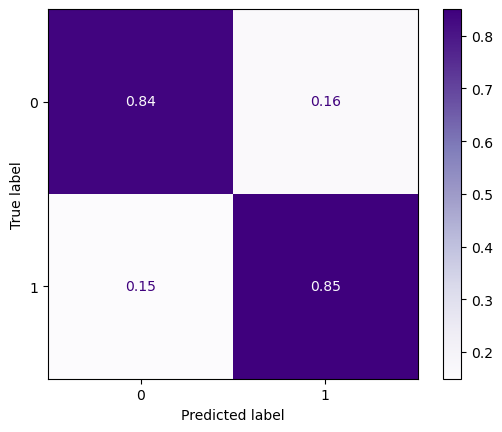

In [15]:
# Initial 
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize='true', cmap='Purples'
);

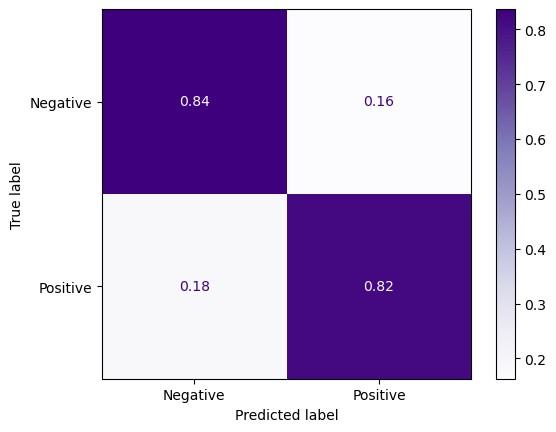

In [71]:
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize='true', cmap='Purples'
    , display_labels=["Negative", "Positive"]
);

In [45]:
# Function to retrain the model

# Trying a lower learning rate (lr) for retraining to counteract overfitting/ decreasing test acc'y; 
optimizer_r = optim.Adam(model.parameters(), lr=1e-4)

def retrain_model(model, train_loader, criterion, optimizer_r, device, epochs=10):
    """Retrains the model for a specified number of epochs."""
    print("Starting retraining...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)
            preds = output.argmax(dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_x.size(0)
        acc = correct / total
        print(f"Epoch {epoch + 1}: Loss={total_loss / total:.4f}, Acc={acc:.4f}")
    print("Retraining complete.")

In [46]:
# Function to reevaluate the model
def reevaluate_model(model, test_loader, device):
    """Evaluates the model on the test set and prints metrics."""
    print("Starting reevaluation...")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Print evaluation metrics
    print(classification_report(all_labels, all_preds, target_names=["neg", "pos"]))
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    ConfusionMatrixDisplay.from_predictions(
        all_labels, all_preds, normalize='true', cmap='Purples'
    )
    print("Reevaluation complete.")

In [47]:
# Example usage:
# Retrain for additional epochs
retrain_model(model, train_loader, criterion, optimizer, DEVICE, epochs=10)

Starting retraining...
Epoch 1: Loss=0.0922, Acc=0.9777
Epoch 2: Loss=0.0735, Acc=0.9827
Epoch 3: Loss=0.0727, Acc=0.9836
Epoch 4: Loss=0.0699, Acc=0.9838
Epoch 5: Loss=0.0659, Acc=0.9836
Epoch 6: Loss=0.0668, Acc=0.9839
Epoch 7: Loss=0.0503, Acc=0.9887
Epoch 8: Loss=0.0577, Acc=0.9872
Epoch 9: Loss=0.0510, Acc=0.9887
Epoch 10: Loss=0.0434, Acc=0.9909
Retraining complete.


Starting reevaluation...
              precision    recall  f1-score   support

         neg       0.81      0.83      0.82     12500
         pos       0.83      0.80      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Confusion Matrix:
[[10392  2108]
 [ 2480 10020]]
Reevaluation complete.


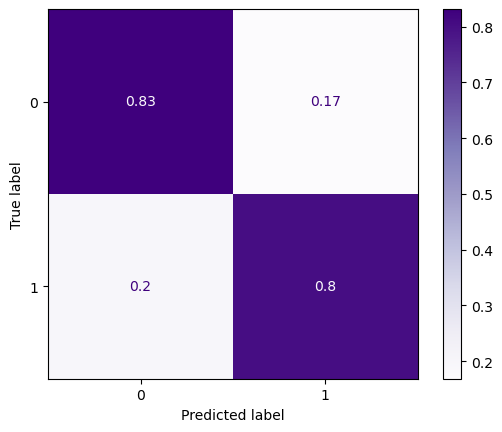

In [48]:
# Reevaluate the model on the test set
reevaluate_model(model, test_loader, DEVICE)

In [ ]:
# reevaluate_model(model, test_loader, DEVICE)
'''
init cm:
array([[10480,  2020],
       [ 1869, 10631]])

cm after retrain and reeval:
array[[10735  1765]
      [ 2383 10117]]

'''